In [40]:
import math
class ag: # AutoGrad
    def log(input):
        output = ag.Scalar(math.log(input.value), inputs=[input], op="log")

        def _backward():
            input.grad += output.grad / input.value
            return None

        output._backward = _backward
        return output

    def exp(input):

        output = ag.Scalar(math.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Scalar(max(0, input.value), inputs=[input], op="relu")

        def _backward():
            if input.value > 0:
                input.grad += output.grad

        output._backward = _backward
        return output


    class Scalar: # Scalars with grads
        def __init__(self,  value, op="", _backward= lambda : None, inputs=[], label=""):

            self.value = float(value)
            self.grad = 0.0

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label


        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order

        def backward(self):
            self.grad = 1.0

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()


        def __add__(self, other):
            assert isinstance(other, ag.Scalar)

            output = ag.Scalar(self.value + other.value,
                               inputs=[self, other], op="add")

            def _backward():
                # pass
                self.grad += output.grad
                other.grad += output.grad

            output._backward = _backward
            return output


        def __mul__(self, other):
            assert isinstance(other, ag.Scalar)
            output = ag.Scalar(self.value * other.value, inputs=[self, other], op="mul")

            def _backward():
                self.grad += other.value * output.grad
                other.grad += self.value * output.grad

                return None

            output._backward = _backward

            return output

        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Scalar(self.value ** exponent, inputs=[self], op=f"pow({exponent})")

            def _backward():
                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output

        def __repr__(self) -> str:
            return str("val:" + str(self.value) + ", grad:" + str(self.grad))



In [41]:
import numpy as np

class Model:
    def __init__(self, n_hidden,rng_seed = 42):
        np.random.seed(rng_seed)

        w1np = np.random.randn(n_hidden)
        b1np = np.random.randn(n_hidden)
        w2np = np.random.randn(n_hidden)
        b2np = np.random.randn(1)

        self.w1 = [ag.Scalar(val) for val in w1np]
        self.b1 = [ag.Scalar(val) for val in b1np]
        self.w2 = [ag.Scalar(val) for val in w2np]
        self.b2 = [ag.Scalar(val) for val in b2np]

        self.n_hidden = n_hidden

        self.parameters = self.w1 + self.b1 + self.w2 + self.b2

    def forward(self, x):
        # x is a 1-dimensional numpy array
        # "upgrade" x into ag.Scalars
        x_scalar = [ag.Scalar(val) for val in x]
        n_samples = len(x_scalar)

        # calculate the forward

        ## YOUR CODE HERE
        # return [ag.Scalar(0.0) for i in range(n_samples)]

        # h[i] is a length n_hidden list, where h[i][j] is the j-th activation on the i-th sample
        h = [ [ag.relu(self.w1[j] * x_i + self.b1[j])  for j in range(self.n_hidden)]  for x_i in x_scalar ]

        # w2h is a list of length n_samples where w2h[i] = is
        w2h =  [ag.Scalar(0) for i in range(n_samples)]
        for i in range(n_samples):
            for j in range(self.n_hidden):
                w2h[i] += self.w2[j] * h[i][j]


        output = [ w2h[i] + self.b2[0] for i in range(n_samples) ]

        return output


class Loss:
    def mse(self, predictions, targets):
        # mean squared error
        assert len(predictions) == len(targets)
        n_samples = len(predictions)
        loss = ag.Scalar(0.0)

        ## YOUR CODE HERE
        # return loss

        for i in range(n_samples):
            error = predictions[i] + ag.Scalar(-1)* ag.Scalar(targets[i])
            loss = loss + error ** 2

        loss = loss * ag.Scalar(1.0 / N)
        return loss

class Optimizer:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for param in self.parameters:
            param.grad = 0.0

    def step(self):
        for param in self.parameters:
            param.value -= self.lr * param.grad




In [42]:
def to_numpy(ag_Scalar_list):
    return np.array([scalar.value for scalar in ag_Scalar_list])


# Generate some synthetic data

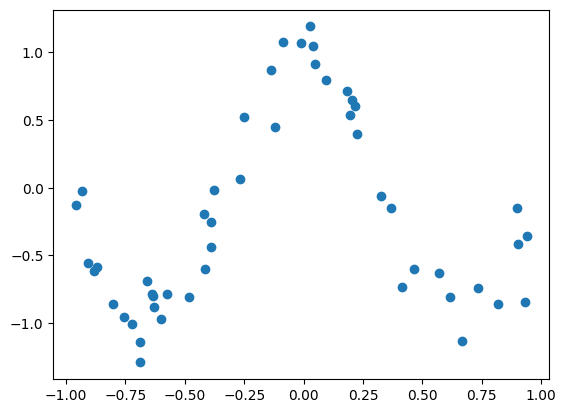

In [43]:
import numpy as np
import matplotlib.pyplot as plt

N = 50

np.random.seed(42)
xnp = 2.0*(np.random.rand(N)-0.5) # note that i'm using rand instead of randn

eps = (1/5)*np.random.randn(N)
ynp = np.cos((3/2)*np.pi*xnp) + eps

plt.scatter(xnp, ynp)

# Visualize the model at the beginning

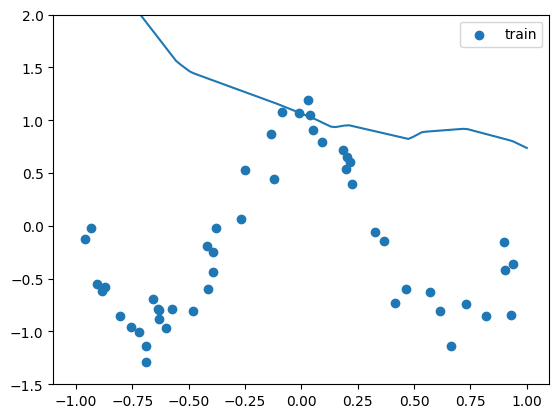

In [44]:
n_hidden = 20
loss_fn = Loss()
model = Model(n_hidden=n_hidden)
output = model.forward(xnp)
loss = loss_fn.mse(output, ynp)
loss.backward()

plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model.forward(x_grid)

plt.plot(x_grid,to_numpy(y_grid))
plt.legend()

# Check gradients!
The following is from `lec03-in-class-ex2-relu-net`.

In [45]:

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return 1.0*(z > 0)

def forward_pass(x, theta):
    w1, b1, w2, b2 = theta["w1"], theta["b1"], theta["w2"], theta["b2"]
    h = np.dot(x, w1[np.newaxis,:]) + b1

    z = np.dot(relu(h), w2) + b2

    return h,z

def compute_gradients(x, y, theta):
    w1, b1, w2, b2 = theta["w1"], theta["b1"], theta["w2"], theta["b2"]
    N = x.shape[0]

    h, z = forward_pass(x, theta)

    dJdw2 = -(2/N) *np.dot(y-z,relu(h))
    dJdb2 = -(2/N) *np.sum(y-z)

    dJdw1 = -(2/N)*np.dot(x.T,(y-z)[:,np.newaxis]*(relu_derivative(h)*w2)).flatten()
    dJdb1 = -(2/N)*np.sum((y-z)[:,np.newaxis]*(relu_derivative(h)*w2),axis=0)

    gradients = {
        "w1": dJdw1,
        "b1": dJdb1,
        "w2": dJdw2,
        "b2": dJdb2
    }

    return gradients
np.random.seed(42)

w1np = np.random.randn(n_hidden)
b1np = np.random.randn(n_hidden)
w2np = np.random.randn(n_hidden)
b2np = np.random.randn(1)
theta = {
    "w1": w1np,
    "b1": b1np,
    "w2": w2np,
    "b2": b2np
}

print("Gradients w.r.t...")
compute_gradients(xnp[:,np.newaxis],ynp,theta)

Gradients w.r.t...


{'w1': array([-0.77812733, -0.        , -0.05983346, -0.01308966, -0.        ,
         1.06162589, -0.1334644 ,  0.33174812, -0.        , -0.74240319,
        -0.        ,  0.40576386, -0.35035664, -0.83648495, -1.5205176 ,
        -0.        ,  1.31182752, -0.        , -0.        , -1.53220044]),
 'b1': array([ 2.35879461, -0.        , -0.09581822, -0.01392784, -0.        ,
        -1.90527052, -0.15487964,  1.45317449, -0.        , -0.96508371,
        -0.        , -1.23002182, -0.56073676,  1.11296206,  2.72883073,
        -0.        , -2.02339678, -0.        , -0.        ,  2.31496312]),
 'w2': array([ 4.15815372e+00, -0.00000000e+00,  3.91046686e-01,  3.06458925e-04,
        -0.00000000e+00,  6.38892958e-01,  7.05611615e-02,  7.57291623e-01,
        -0.00000000e+00,  6.87956077e-02, -0.00000000e+00,  6.40725115e+00,
         1.14052576e-01,  6.91931344e-01,  4.72100485e+00, -0.00000000e+00,
         2.08679348e+00, -0.00000000e+00, -0.00000000e+00,  2.68532821e+00]),
 'b2': 3.194

In [57]:
print(np.array([w1_.grad for w1_ in model.w1]))
print(np.array([b1_.grad for b1_ in model.b1]))
print(np.array([w2_.grad for w2_ in model.w2]))
print(np.array([b2_.grad for b2_ in model.b2]))


[-0.77812733  0.         -0.05983346 -0.01308966  0.          1.06162589
 -0.1334644   0.33174812  0.         -0.74240319  0.          0.40576386
 -0.35035664 -0.83648495 -1.5205176   0.          1.31182752  0.
  0.         -1.53220044]
[ 2.35879461  0.         -0.09581822 -0.01392784  0.         -1.90527052
 -0.15487964  1.45317449  0.         -0.96508371  0.         -1.23002182
 -0.56073676  1.11296206  2.72883073  0.         -2.02339678  0.
  0.          2.31496312]
[4.15815372e+00 0.00000000e+00 3.91046686e-01 3.06458925e-04
 0.00000000e+00 6.38892958e-01 7.05611615e-02 7.57291623e-01
 0.00000000e+00 6.87956077e-02 0.00000000e+00 6.40725115e+00
 1.14052576e-01 6.91931344e-01 4.72100485e+00 0.00000000e+00
 2.08679348e+00 0.00000000e+00 0.00000000e+00 2.68532821e+00]
[3.19417922]


# Train!

In [ ]:

n_hidden = 20
model = Model(n_hidden=n_hidden)
optimizer = Optimizer(model.parameters, lr=0.1)


for epoch in range(100):
    optimizer.zero_grad()
    output = model.forward(xnp)
    loss = loss_fn.mse(output, ynp)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Iteration {epoch}, Loss: {loss.value}")

Iteration 0, Loss: 3.6301518820544976
Iteration 10, Loss: 0.25826390197713983
Iteration 20, Loss: 0.18628074533544114
Iteration 30, Loss: 0.16072217110467135
Iteration 40, Loss: 0.1467600095145268
Iteration 50, Loss: 0.13821133135695673
Iteration 60, Loss: 0.13148817078641828
Iteration 70, Loss: 0.12566843762326205
Iteration 80, Loss: 0.12086485496274214
Iteration 90, Loss: 0.11662280564984422


# Visualize the model at the end of the training

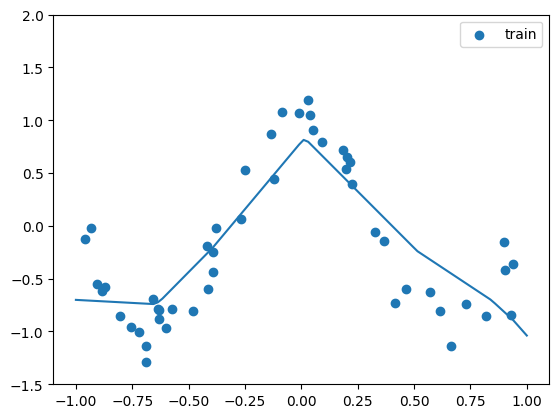

In [ ]:
plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model.forward(x_grid)

plt.plot(x_grid,to_numpy(y_grid))
plt.legend()